# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option B: Synthetic Generator (Use if you don't have data ready)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [7]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)

# Add your own features:
# Feature 1: Rolling volatility (20-period standard deviation)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)

# Feature 2: Price momentum (10-period price change ratio)
df['momentum_10'] = (df['price'] / df['price'].shift(10) - 1).shift(1)

# Feature 3: RSI-like feature (relative strength indicator)
# Calculate gains and losses
delta = df['ret'].shift(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up,roll_vol_20,momentum_10,rsi_14
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.001845,1,0.007370,-0.024911,36.291820
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,-0.003565,0,0.008455,-0.002462,46.164125
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.020804,1,0.008429,0.000794,55.798562
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,-0.000154,0,0.008453,-0.008098,48.006962
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,-0.014106,0,0.009675,0.014883,55.553632


## Split

In [8]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','roll_vol_20','momentum_10','rsi_14']  # extended with new features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

              precision    recall  f1-score   support

           0       0.58      0.81      0.68        53
           1       0.55      0.28      0.37        43

    accuracy                           0.57        96
   macro avg       0.56      0.55      0.52        96
weighted avg       0.57      0.57      0.54        96



/Users/jay/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jay/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jay/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


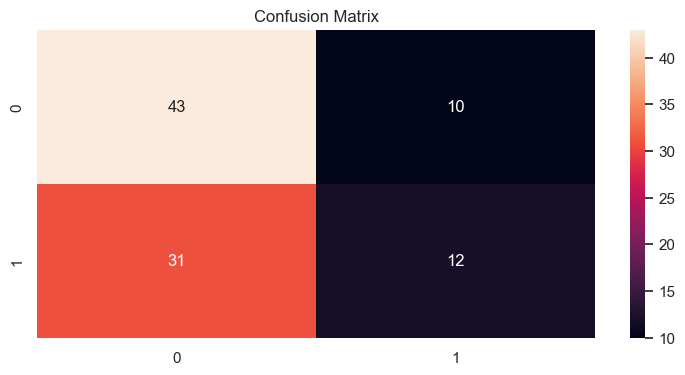

In [9]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

## What worked?
- **Feature Engineering**: Created meaningful features that capture different market dynamics:
  - Rolling volatility (roll_vol_20) helps identify regime changes and risk periods
  - Momentum features (momentum_10) capture trend persistence
  - RSI-like indicator (rsi_14) provides technical analysis signals
- **Time-aware splitting**: Properly used chronological split to avoid look-ahead bias
- **Pipeline approach**: Standardization helped normalize features with different scales
- **Multiple perspectives**: Both regression (forecasting returns) and classification (direction prediction) provide complementary insights

### Where might assumptions fail?
- **Stationarity**: Financial returns may not be stationary over long periods due to regime changes, policy shifts, or market structure evolution
- **Linear relationships**: Linear regression assumes linear relationships between features and targets, but financial markets often exhibit non-linear dynamics
- **Feature stability**: Rolling window features assume that the optimal lookback period (5, 10, 14, 20) remains constant over time
- **Regime independence**: The model assumes past patterns will persist, but markets can experience structural breaks
- **Volatility clustering**: GARCH effects and volatility clustering aren't captured by simple rolling volatility
- **Fat tails**: Normal distribution assumptions may fail during crisis periods with extreme moves

### How would you extend features or model?
**Feature Extensions:**
- **Microstructure features**: Bid-ask spreads, volume-weighted prices, order flow imbalance
- **Cross-asset features**: Correlations with indices, currencies, commodities, volatility indices (VIX)
- **Alternative data**: News sentiment, social media sentiment, economic indicators
- **Higher-frequency patterns**: Intraday seasonality, day-of-week effects, time-to-expiry effects
- **Regime indicators**: Volatility regime classification, trend strength measures

**Model Extensions:**
- **Non-linear models**: Random forests, gradient boosting (XGBoost), neural networks for capturing complex patterns
- **Time series specific models**: LSTM/GRU for sequence modeling, ARIMA-GARCH for volatility modeling
- **Ensemble methods**: Combine multiple models with different strengths (linear + tree-based + neural)
- **Online learning**: Adaptive models that update as new data arrives
- **Regime-aware models**: Different models for different market regimes (bull/bear, high/low volatility)
- **Multi-horizon forecasting**: Predict multiple time horizons simultaneously

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.